# Building and Optimizing an Emulator

Let's build an emulator for a quantum scattering problem with an optical potential! In this tutorial, we will show how to write your own interaction from scratch, rather than use the built-in versions, as well as walk you through some of the ideas behind the reduced basis method. We will choose neutron scattering on the $^{40}$ Ca nucleus as our test problem. In particular, we want to build an emulator that can predict the differential elastic scattering cross section for this reaction, at a given energy as quickly and accurately as possible.


The following form of Schrodinger equation results from choosing an optical potential, $V(r,\alpha)=U(r,\alpha)/2\mu$ as the neutron-nucleus interaction potential energy, which depends on some parameters $\alpha$, and reduced mass \$mu$. We decompose the radial part of the Hamiltonian into partial waves, reduce it by dividing the wavefunction by $r$, such that $\phi_{\ell}(r) = r \chi_\ell(r)$ for a given radial wavefunction $\chi_\ell(r)$. We then subtract the energy, $\hbar^2 p^2/2\mu$, from both sides, and divide by $\hbar^2/2\mu$ to yield:


\begin{equation}
    F_\alpha(\phi)=\left(-\frac{d^2}{dr^2}+\frac{\ell(\ell+1)}{r^2}+U(r,\alpha)-p^2\right)\phi(r)=0.
\end{equation}


Here, $\ell$ is the angular momentum quantum number, and $p$ is the asymptotic linear momentum. Internally within `rose`, we re-scale the equation to work in dimensionless units $s=rp$. Our reduced basis expansion of $n$ basis can be written as:

\begin{equation}
   \phi(r) \approx \phi_0(r) + \sum_k^n a_k\phi_k(r)
\end{equation}


The goal of this tutorial is to demonstrate how to build such an emulator with `rose`, and then choose the optimal emulator configuration to accomplish this. The full derivation of the methodology behind `rose` is given in [this paper](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.109.044612), and explained pedagogically in [this jupyter-book](https://dr.ascsn.net/landing.html), particularly chapters 1-3.


Let's get to it then. First, we'll import all the modules we need and set up the scattering system.

In [1]:
# (if you don't have it already)
#!pip install nuclear-rose

import rose
from numba import njit  # we need to this to Just-In-Time (JIT) compile our interaction

# other nice things
import numpy as np
import time
import os
from scipy.stats import qmc

# import stuff for nice plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as sps
from tqdm import tqdm
import random
import datetime

print(rose.__version__)

1.1.3


In [2]:
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
from matplotlib import rcParams
from rose.training import multiple_formatter

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

# plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
# rcParams[
#     "text.latex.preamble"
# ] = r"\usepackage{amssymb} \usepackage{amsmath} \usepackage{braket}"
plt.rc("text", usetex=False)

rcParams["legend.fontsize"] = 12
rcParams["font.size"] = 12
rcParams["font.weight"] = "normal"
rcParams["xtick.labelsize"] = 12.0
rcParams["ytick.labelsize"] = 12.0
rcParams["lines.linewidth"] = 2.0
rcParams["xtick.major.pad"] = "10"
rcParams["ytick.major.pad"] = "10"
rcParams["image.cmap"] = "BuPu"

In [3]:
Starting_time=time.time()

## Setting up the scattering system

We start by making some preliminary definitions for constants.

In [4]:
# targets and projectiles defined by (A,Z)
Ca40 = (40, 20)
proton = (1,1)

# set up kinematics
E_lab = 14.1  # MeV - like from a DT generator
mu, E_com, k, eta = rose.kinematics(target=Ca40, projectile=proton, E_lab=E_lab)

# domain of the differential cross section; the observable we want to emulate
# we will evaluate the accuracy of our emulator by comparing dsigma/dtheta on this domain
angles = np.linspace(1, 179, 200) * np.pi / 180

## Define the interaction: an optical model potential

Let's define the functional forms for the interaction potentials we will use. We will use standard forms of the optical potential, with default parameters for $^{40}$Ca, as defined by [Koning and Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw). Although these are already implemented in `rose.koning_delaroche`, we will implemement them from scratch below for purposes of demonstration on how to provide your own interaction in `rose`.

The potential we use includes the following terms, each with a set of parameters:

1. complex volume term with a Woods-Saxon shape; $V_v$, $W_v$, $R_v$, $a_v$
2. imaginary surface-peaked term with a Woods-Saxon derivative shape; $W_d$, $R_d$, $a_d$
3. complex spin-orbit (SO) coupling term with a Woods-Saxon derivative shape; $V_{so}$, $W_{so}$, $R_{so}$, $a_{so}$.


\begin{equation}
    \begin{aligned}
      &V(r;\alpha,\ell,j) =-(V_v +iW_v)f_\text{WS}(r,R_v,a_v)  \\
      &-i4a_dW_d \frac{d}{dr}f_\text{WS}(r,R_d,a_d) \\
      &+2\ell\cdot s (V_{so} + iW_{so})  \Big(\frac{\hbar}{m_\pi c}\Big)^2 \frac{1}{r} \frac{d}{dr}f_\text{WS}(R_{so},a_{so}),
    \end{aligned}
\end{equation}


The Woods-Saxon functional form (and it's derivative) is our model for the geometric shape of the effective potential the neutron feels as a function of it's distance from the $^{40}$ Ca nucleus. It looks like this:

\begin{equation}
f(r;R,a) = \frac{1}{1 - \exp{\frac{r-R}{a}}}.
\end{equation}


All depth parameters ($V_i$, $W_i$) are given in MeV, and geometric parameters $r_i$ and $a_i$ are given in fm. We define our vector of parameters as 

\begin{equation}
\boldsymbol{\alpha} = \begin{bmatrix}
V_v &  W_v & R_v & a_v & W_d & R_d & a_d & V_{so} & W_{so} & R_{so} & a_{so}
\end{bmatrix}
\end{equation}

One final thing - we will need to decorate our implementation of this interaction with `@njit`, so `rose` can compile it for performance.

Let's set this up:


In [5]:
from rose.utility import woods_saxon, woods_saxon_prime


# total potential with a real and central term (with the same geometry)
# and imaginary surface-peaked term, but no SO coupling
@njit
def optical_potential(r, theta):
    Vv, Wv, Wd, Vso, Wso, Rv, Rd, Rso, av, ad, aso = theta
    return (1j * Wv - Vv) * woods_saxon(r, Rv, av) - (4j * ad * Wd) * woods_saxon_prime(
        r, Rd, ad
    )


# spin orbit interaction constant
mso = 1.0 / rose.constants.MASS_PION


# spin-orbit (SO) coulpling term - a function of l dot s, l being the orbital angular momentum
# and s being the spin of the neutron
@njit
def spin_orbit_potential(r, theta, ldots):
    Vv, Wv, Wd, Vso, Wso, Rv, Rd, Rso, av, ad, aso = theta
    return (Vso + 1j * Wso) * mso**2 * ldots * woods_saxon_prime(r, Rso, aso) / r


# the total number of parameters
nparams = 11

In [6]:
# the default parameters determined by Koning & Delaroche
VvKD = 46.7238
WvKD = 1.72334
WdKD = -7.2357
VsoKD = 6.1
WsoKD = -3.1

RvKD = 4.0538
RdKD = 4.4055
RsoKD = 1.01 * 40 ** (1.0 / 3.0)

avKD = 0.6718
adKD = 0.5379
asoKD = 0.60

# This is the value of the parameters coming from the Koning-Delaroche parametrization.
# Taken from https://www-nds.iaea.org/RIPL-3/
alpha_central = np.array(
    [VvKD, WvKD, WdKD, VsoKD, WsoKD, RvKD, RdKD, RsoKD, avKD, adKD, asoKD]
)

## Set up the training and testing regions for the emulator

It is now our goal to define an emulator that, given an arbitrary point in a closed subset of this 11D space, reproduces the scattering solutions of the Schrödinger equation for the center-of-mass frame of a 14.1 MeV neutron and a $^{40}$ Ca nucleus. To do this, we will use a high-fidelity (HF) solver to construct a basis of solutions as we perturb $\boldsymbol{\alpha}$ around our region of interest, and then construct a suitable reduced basis emulator from it. 

Notice that the functional form of the Woods-Saxon (and its derivative) is not a simple linear function of the parameters $R$ and $a$. To be more precise, we can't factorize this function into the product of functions of just the parameters $R$ and $a$, and another function of just the domain of the problem $r$. A mathematician would say that this operator is not "affine" in the geometric parameters. To handle emulating the potential operator, we will need to construct an approximation that is factorizable using something called the Empirical Interplation Method (EIM). Chapters 2 and 3 of [this book](https://dr.ascsn.net/) contain a more detail view (within a nuclear physics context) of the reduced basis method and the empirical interpolation method we use in ROSE. 

In summary, the EIM consists of approximating the potential with $m$ reduced basis in the same way as we did for our solutions:

\begin{equation}
V(r; \alpha)  \approx V_\text{EIM} (r; \alpha)  = \sum_k^m \beta_k(\alpha) V_k(r).
\end{equation}

Fortunately, ROSE will handle all of these details for us, so we don't have to get our hands too dirty! Let's take a look at how to use ROSE to make ourselves a nice emulator.

We will create training boundaries 20% above and below our mean values for the parameters, and therefore define the bounds of a hyper-box in our 11D parameter space that contains this region of interst. We will train our emulator with random samples of $\alpha$ from this box, and we would like to be accurate throughout the entire box.

In [7]:
scale_training = 0.2
bounds = np.array(
    [
        alpha_central - np.fabs(alpha_central * scale_training),
        alpha_central + np.fabs(alpha_central * scale_training),
    ]
).T

In [8]:
from rose.training import sample_params_LHC  # Latin Hypercube sampling

#  train/test split
n_test = 20
n_train = 80

seed_train = 13
seed_test = 14

training_samples = sample_params_LHC(
    n_train, alpha_central, scale=scale_training, seed=seed_train
)
test_samples = sample_params_LHC(
    n_test, alpha_central, scale=scale_training, seed=seed_test
)

## Construct the interaction space, high-fidelity solver, and emulator

Great, we have all the points we need to sample. Now let's define an `InteractionEIMSpace` in `rose`, which encodes the original, and Empirically-Interpolated, potentials we've defined; one for each partial wave. Then we will use this to construct our emulators and our High-Fidelity (HF) solver, and take a look at how snapshots of the HF solutions vary over our training space.  We will use the default EIM setup. ROSE will automatically use the exact potential for the HF solver, and the EIM decomposed potential for emulation.

By the way, we like to call HF solutions of our system "snapshots". In this case, we use snapshots to refer to the test observables (differential cross sections), but we will also use it to refer to the training wavefunctions we generate with the HF solver, which ROSE uses to construct the reduced basis.

We will start by using a reduced basis of 4 elements, and the same number of EIM terms as there are parameters in $\boldsymbol{\alpha}$; in this case, 11. We will pass in the bounds of our parameter space, and the `InteractionEIMSpace` object will automatically find 1000 (by default) well-distributed points in our parameter space to train the EIM factorization. These are fairly sensible defaults, but can be easily changed.

In [9]:
# Finally, we can invoke ROSE. Let's build an InteractionEIMSpace, running over lmax partial
# waves, with the optical potential we defined above.
interactions = rose.InteractionEIMSpace(
    coordinate_space_potential=optical_potential,
    n_theta=nparams,
    mu=mu,
    energy=E_com,
    is_complex=True,
    spin_orbit_term=spin_orbit_potential,
    training_info=bounds,
)
# that was easy!

Now that we have our interaction, let's set up 1) a HF solver and 2) an emulator. In ROSE, these tasks are handled by the same object; `ScatteringAmplitudeEmulator`. We will set one up, and calculate snapshots of the cross sections at our test points.

In [10]:
# let's build our first reduced basis emulator
base_solver = rose.SchroedingerEquation.make_base_solver(
    s_0=6 * np.pi, rk_tols=[1e-10, 1e-10], domain=np.array([1e-8, 8 * np.pi])
)
emulator = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    training_samples,
    base_solver=base_solver,
    n_basis=5,
    angles=angles,
    scale=True,
    use_svd=True,
)

100%|██████████████████████████████████████████████████████████| 16/16 [01:22<00:00,  5.18s/it]


Great, now let's compare some exact and emulated differential cross sections!

In [11]:
%%time
# calculate the "ground truth" (high fidelity) differential cross section 
# for the 50 test parameters we sampled
ground_truth_xs = []
for params in tqdm(test_samples):
    ground_truth_xs.append(emulator.exact_xs(params).dsdo)

100%|██████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.28it/s]

CPU times: total: 3.36 s
Wall time: 15.7 s


Great, we have our ground truth test cross section! Now let's reproduce them with our emulator.

In [12]:
%%time
# calculate the emulated differential cross section for the 50 test parameters we sampled
emulated_xs = []
for params in tqdm(test_samples):
    emulated_xs.append(emulator.emulate_xs(params).dsdo)

100%|████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1665.23it/s]

CPU times: total: 0 ns
Wall time: 13 ms


Notice how much faster that was. Let's plot the results to see how we did:

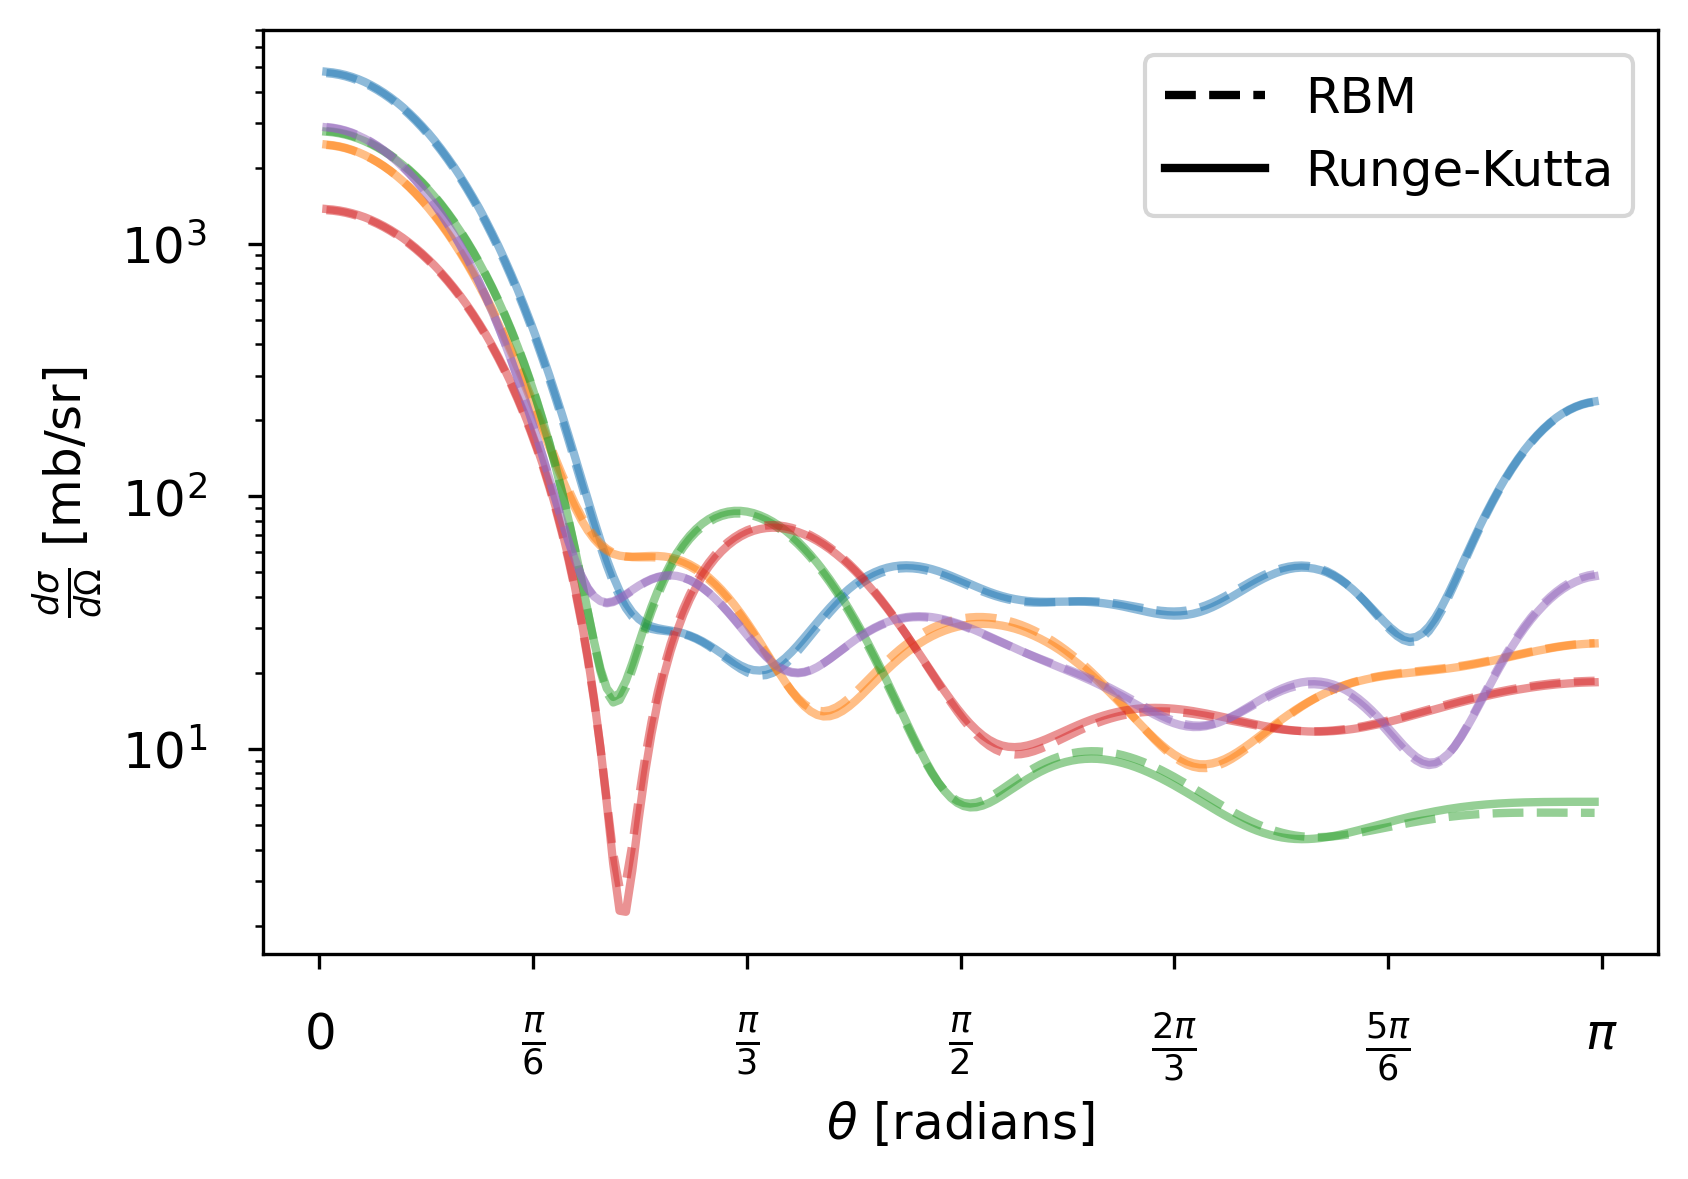

In [13]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

for i in range(5):
    p = ax.plot(angles, ground_truth_xs[i], alpha=0.5)
    ax.plot(
        angles, emulated_xs[i], linestyle="dashed", color=p[0].get_color(), alpha=0.5
    )

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--"),
    Line2D([0], [0], color="k"),
]
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=6)))

ax.legend(legend_styles, ["RBM", "Runge-Kutta"])
ax.set_yscale("log")
plt.xlabel(r"$\theta$ [radians]")
plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]")
plt.show()

This is not bad, but we can do better by optimizing the hyperparameters a bit. Many computational methods have one or more handles to trade off better accuracy at the cost of loss of speed. In the case of the reduced basis emulator we can directly change 1) the size of the reduced basis, and 2) the number of terms in the EIM expansion. Remember, we used 5 reduced basis elements, and 11 EIM terms. 

In `rose.training`, there are some functions that can help us test different hyperparameter configurations.

Let's choose a few configurations for the emulator and compare them. Our metrics will be:
1. time to generate solution
2. accuracy of solution (relative to the HF solver with a very small tolerance)

For each of the configs we run, we will set up the emulator, and calculate these 2 metrics. First, we will do the offline training for all the emulator configs. This is where most of the computational expense of an emulator comes in; training in the offline stage. Once each partial wave, at each paramater sample point, has it's reduced basis trained, the online stage, where we calculate observables, should be much faster.

In [ ]:
#[basis size, number of terms in EIM decomposition]
sae_configs = [(5, 5), (10, 10), (15, 15), (20, 20)]
_, emulators = rose.training.build_sae_config_set(
    sae_configs,
    interactions,
    training_samples,
    bounds,
    angles=angles,
    base_solver=base_solver
)

 25%|███████████████                                             | 1/4 [00:44<02:13, 44.53s/it]

We will use the handy class `CATPerformance` to time and store the outputs and residuals of each of our emulators. We will write these objects to disk, so that we can read them later if we want to.

In [ ]:
from rose.training import CATPerformance
import pickle
from pathlib import Path

In [ ]:
%%time
rbm_performances = []
for solver, config in zip(emulators, sae_configs):
    label = r"$\left({:d} , {:d}\right)$".format(*config)
    fpath = Path("perf_rbm_{:d}_{:d}.pkl".format(*config))
    if fpath.is_file():
        with open(fpath, "rb") as f:
            perf = pickle.load(f)
            rbm_performances.append(perf)
    else:
        rbm_performances.append(
            CATPerformance(
                benchmark_runner=lambda sample: solver.emulate_xs(sample).dsdo,
                benchmark_inputs=test_samples,
                benchmark_ground_truth=ground_truth_xs,
                label=label,
                n_timing=10,
            )
        )
        with open(fpath, "wb") as f:
            pickle.dump(rbm_performances[-1], f)

We would like to compare the results of our emulartors to HF solvers at a variety of tolerances, to make sure using an emulator is actually worthwhile, as opposed to just cranking down the tolerances on our HF solver. To do that, we'll use `ScatteringAmplitudeEmulators.HIFI_solver` to set up just the high-fidelity solver without wasting time training.  

In [ ]:
# log of tolerance for each hifi solver
rk_logtol = [-5, -6, -7]
hifi_solvers = []
for tols in rk_logtol:
    hf_tols = [10 ** (tols), 10 ** (tols)]
    solver = rose.SchroedingerEquation(None, hf_tols)
    hifi_solvers.append(
        rose.ScatteringAmplitudeEmulator.HIFI_solver(
            interactions,
            solver,
            angles=angles,
        )
    )

And now we do the same with `CATPerformance` for this set of hifi solvers:

In [ ]:
%%time
hifi_solver_performances = []
for solver, tols in zip(hifi_solvers, rk_logtol):
    label = r"$\left[{:1.0e} , {:1.0e}\right]$".format(10**tols, 10**tols)
    fpath = Path("perf_hifi_{:1.0e}_{:1.0e}.pkl".format(10**tols, 10**tols))
    if fpath.is_file():
        with open(fpath, "rb") as f:
            perf = pickle.load(f)
            hifi_solver_performances.append(perf)
    else:
        hifi_solver_performances.append(
            CATPerformance(
                benchmark_runner=lambda sample: solver.exact_xs(sample).dsdo,
                benchmark_inputs=test_samples,
                benchmark_ground_truth=ground_truth_xs,
                label=label,
                n_timing=1,
            )
        )
        with open(fpath, "wb") as f:
            pickle.dump(hifi_solver_performances[-1], f)

Finally, let's plot the results to see how our emulators do:

In [ ]:
# plot the Computational Accuracy vs. Time (CAT)
from rose.training import CAT_plot

fig, ax = CAT_plot(
    [rbm_performances, hifi_solver_performances],
    labels=["RBM [$n_{rbm}$, $n_{eim}$]", "Runge-Kutta [rtol, atol]"],
    border_styles=[":", "-"],
)
ax.set_ylabel(r"median relative error in $d \sigma / d \Omega$ [\%]", fontsize=12)
plt.ylim(1e-4, 100)
plt.xlim(5e-4, 10)

Well how about that! No matter how you crank the hifi tolerances, you just can't beat the RBM in time and accuracy.



Now we can decide empirically which emulator configuration is the fastest for a given accuracy, and we can quantitatively see that the emulators are categorically superior to the HF solver when it comes to getting fast and accurate differential cross sections. 

Notice, increasing the number of EIM terms can increase accuracy without making too much large impact on time. We would expect diminishing returns for more EIM terms, however, and if the error is dominated by too small of a basis (e.g. the case of the (3,5) emulator) then increasing the EIM terms will not improve the emulator at all. For basis size, since `rose` has to actually solve a system of equations proportional to this variable, we except the time to scale roughly with the square of the basis size, so the impact on time is much larger. Since we only trained with 50 samples, in this case increasing the basis number further will saturate the median error in around 10^-4, but further improvement can be done by providing more training points.

## Spot checks
Let's plot a few cross sections, wave functions, and phase shifts to see how the emulator compared to the high-fidelity.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

perf_2_plot = rbm_performances[-1]

for i in range(int(n_test/2)):
    p = ax.plot(angles, ground_truth_xs[i], alpha=0.5)
    ax.plot(angles, 
            perf_2_plot.runner_output[i,...], 
            linestyle= ":",
            color=p[0].get_color(), 
           # alpha=0.5
           )

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--"),
    Line2D([0], [0], color="k"),
]
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=6)))

ax.legend(legend_styles, [f"RBM {perf_2_plot.label}", "Runge-Kutta"])
ax.set_yscale("log")
plt.xlabel(r"$\theta$ [radians]")
plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]")

We can do some spot checks to make sure our chosen emulator effectively emulates wavefunctions, phase shifts, and the potential itself with negligible loss of accuracy.

In [ ]:
test = test_samples[0] # grab a test sample
sae = emulators[-1] # which emulator config to test

In [ ]:
solutions_rk = sae.exact_wave_functions(test)
solutions_rbm = sae.emulate_wave_functions(test)
# match phases
for l in range(len(solutions_rk)):
    for j in range(len(solutions_rk[l])):
        i = np.argmax(solutions_rk[l][j])
        solutions_rbm[l][j] *= (
            solutions_rk[l][j][i] / solutions_rbm[l][j][i])

In [ ]:
from rose.training import compare_partial_waves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=600)
fig.patch.set_facecolor("white")

compare_partial_waves(
    sae.rbes[0][0].basis.rho_mesh,
    [solutions_rk[0:3], solutions_rbm[0:3]],
    ["Runge-Kutta", "RBM"],
    fig,
    ax1,
    ax2,
)
plt.tight_layout()

In [ ]:
deltas_rk = sae.exact_phase_shifts(test)
deltas_rbm = sae.emulate_phase_shifts(test)

In [ ]:
from rose.training import plot_phase_shifts, compare_phase_shifts_err
from matplotlib import ticker

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, sharex=True, figsize=(8, 4), height_ratios=[1, 0.5], dpi=600
)
fig.patch.set_facecolor("white")

compare_phase_shifts_err(
    deltas_rk,
    deltas_rbm,
    "Runge-Kutta",
    "RBM",
    fig,
    ax1,
    ax2,
    ax3,
    ax4,
    small_label1="RK",
    small_label2="RBM",
)

plt.tight_layout()

In [ ]:
from matplotlib.lines import Line2D

f, ax = plt.subplots(1,1, figsize=(6,4), facecolor="white", dpi=600)

s_mesh = sae.rbes[0][0].basis.rho_mesh
for sample in test_samples[::2]:
    p = plt.plot(s_mesh, sae.rbes[0][0].interaction.tilde(s_mesh, sample), alpha=0.5)[0]
    plt.plot(
        s_mesh,
        sae.rbes[0][0].interaction.tilde_emu(sample),
        ":",
        alpha=0.5,
        color=p.get_color(),
    )
legend_styles = [
    Line2D([0], [0], color="tab:gray", linestyle=":", alpha=0.8),
    Line2D([0], [0], color="tab:gray", alpha=0.8),
]
leg = plt.legend(
    legend_styles,
    ["EIM", "Exact",],
    loc="lower right",
)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/2))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=2)))
plt.ylabel(r"$U(s; \alpha)$")
plt.xlabel(r"$s = kr$")
plt.xlim([0,8])

In [ ]:
Ending_time=time.time()

print("Total time to run the notebook (minutes):")

print(round((Ending_time-Starting_time)/60))